In [34]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from scipy.stats import sem
import matplotlib.cm as cm
from configs import engram_dir
import sys

In [53]:
sys.path.append(os.path.abspath('../scripts/model_parameters'))

In [ ]:
from gridworld import parameter_map

# Helper functions for gathering data

In [2]:
def smooth(xs, ys, n=3):
    vals = np.copy(ys)
    smoothed = np.convolve(ys, np.ones(n)/n, mode='same')
    vals[1:-1] = smoothed[1:-1]
    return vals

In [3]:
def get_df(z, pfiles):
    data = {
        'valid_score': [], 'valid_steps':[], 'dims': [],
        'episode': [], 'model': [], 'z': [], 'step': [],
        'model_iter': []}
    for pickle_file in pfiles:
        with open(pickle_file, 'rb') as f:
            results = pickle.load(f)
        valid_score = results['valid_score']
        valid_steps = results['valid_steps_per_ep']
        episode = results['episode']
        model = results['model']
        step = results['step']
        for i in range(len(valid_score)):
            if valid_score[i] == None: continue
            data['valid_score'].append(valid_score[i])
            data['valid_steps'].append(valid_steps[i])
            data['dims'].append(z)
            data['episode'].append(episode[i])
            data['model'].append(model[i])
            data['z'].append(z)
            data['step'].append(step[i])
            data['model_iter'].append(results['model_iter'][i])
    df = pd.DataFrame(data)
    return df

In [4]:
def find_model_directories(directory_path, model):
    all_files_dirs = os.listdir(directory_path)
    pattern = f'\\b{model}(\\d*)\\b'  # Using word boundaries to ensure complete matches
    matches = [re.search(pattern, item) for item in all_files_dirs]
    
    # Filter out None values (i.e., items that didn't match) and return a list of tuples
    return [(match.group(0), int(match.group(1)) if match.group(1) else None) for match in matches if match]

# Helper functions for plotting

In [16]:
def get_colors(models):
    cmap = cm.get_cmap('Oranges')
    c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
    colors = []
    for model in models:
        if model.startswith('mf'):
            colors.append('C0')
        elif model.startswith('entro'):
            colors.append('C2')
        elif model.startswith('iqn'):
            colors.append('C4')
        elif model.startswith('g0.8'):
            colors.append(cmap(c_steps[3]))
        elif model.startswith('g0.5'):
            colors.append(cmap(c_steps[2]))
        elif model.startswith('g0.25'):
            colors.append(cmap(c_steps[1]))
        elif model.startswith('g0'):
            colors.append(cmap(c_steps[0]))
        else:
            colors.append('black')
    return colors

In [17]:
def plot(df, models, savename=None, figsize=(6.4*0.75, 4.8*0.75)):
    colors = get_colors(models)
    
    # Process model values
    new_df = df.copy()
    smooth_line = True
    new_df['episode'] = new_df['episode']//5*5
    episodes = np.unique(new_df['episode'])
    fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
    for _idx, model in enumerate(models):
        means = []
        sems = []
        for ep in episodes:
            vals = new_df[(new_df['model']==model) & (new_df['episode']==ep)]
            vals = vals['valid_score']
            means.append(np.mean(vals))
            sems.append(sem(vals))
        means = np.array(means)
        sems = np.array(sems)
        mean_lowerbound = means - sems
        mean_upperbound = means + sems

        smooth_n = 5
        means = smooth(episodes, means, smooth_n)
        mean_lowerbound = smooth(episodes, mean_lowerbound)
        mean_upperbound = smooth(episodes, mean_upperbound)

        ax.plot(episodes[:-smooth_n], means[:-smooth_n], label=model, color=colors[_idx])
        ax.fill_between(
            episodes[:-smooth_n], mean_lowerbound[:-smooth_n],
            mean_upperbound[:-smooth_n], alpha=0.4, color=colors[_idx])
    plt.ylabel('Episode Score')
    plt.xlabel('Training Steps')
    #plt.tight_layout()
    if savename is not None:
        plt.savefig(savename + '.png', dpi=300, transparent=True)
    plt.show()

# Initial Gridworld Experiment

In [13]:
# Gridworld task, with |z| = 11

z = 7
pfiles = []

models = [
    'mf0',
    'entro-2',
    'g0_-2_entro-2',
    'iqn_mf1'
    ]
discounts = [0.9, 0.9, 0.9, 0.7]

for model, discount in zip(models, discounts):
    pickle_dir = f'{engram_dir}pickles/gridworld_discount{discount}_'
    pickle_dir += f'eps1.0_dm_dim{z}_shuffobs/'
    for pfile in os.listdir(pickle_dir):
        if not pfile.startswith(model): continue
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(z, pfiles)

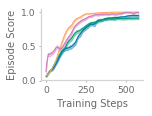

In [14]:
plot(
    df, models,
    #savename='1b',
    figsize=(2, 1.5))

# Testing $\gamma$ reward transfer

In [132]:
pfiles = []
net_yaml = 'dm' #_large_q'
z = 24
pickle_dir = f'{engram_dir}pickles/gridworld_discount0.9_eps1.0_{net_yaml}_dim{z}_shuffobs/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(z, pfiles)

In [133]:
#models = parameter_map['selected_models_large_q']()[0]
models = parameter_map['selected_models_grid_shuffle']()[0]

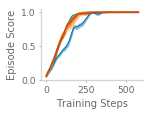

In [134]:
plot(
    df, models,
    #savename='2b_pt1',
    figsize=(2, 1.5))

In [135]:
pfiles = []
pickle_dir = f'{engram_dir}pickles/frozentransfer_gridworld_discount0.9_eps1.0_{net_yaml}_dim{z}_shuffobs/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(z, pfiles)

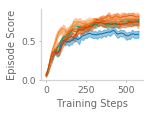

In [136]:
plot(
    df, models,
    #savename='2b_pt2',
    figsize=(2, 1.5))

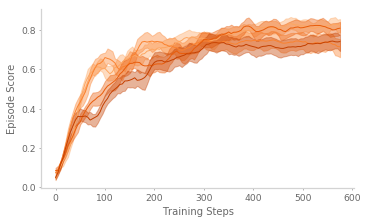

In [141]:
plot(
    df, ['g0_-2_entro-2', 'g0.25_-2_entro-2',
 'g0.5_-3_entro-2',
 'g0.8_-4_entro-2'],
    #savename='2b_pt2',
    figsize=(5,3))

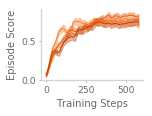

In [138]:
plot(
    df, ['g0.25_-2_entro-2',
 'g0.5_-3_entro-2',
 'g0.8_-4_entro-2'],
    #savename='2b_pt2',
    figsize=(2, 1.5))

# Testing transition revaluation transfer

In [34]:
base = 'new_gridworld8x8_eps0.4_shuffobs'
net_yaml = 'dm_large_q'
z = 17

In [35]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/{base}_{net_yaml}_dim{z}/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(base, z, pfiles, net_yaml)

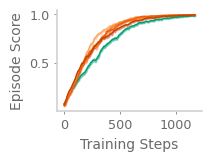

In [36]:
plot(
    df, ['mf', 'entro2', 'g0_-2_entro-1', 'g0.25_-2_entro0',
     'g0.5_-2_entro0', 'g0.8_-4_entro0'],
   savename='2g_pt1', figsize=(2, 1.5))

In [25]:
base = 'transitionreval_new_gridworld8x8_eps0.4_shuffobs'
net_yaml = 'dm_large_q'
z = 17

In [26]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/{base}_{net_yaml}_dim{z}/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(base, z, pfiles, net_yaml)

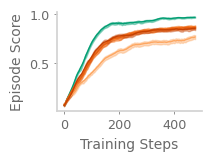

In [32]:
plot(
    df, ['mf', 'entro2', 'g0_-2_entro-1', 'g0.25_-2_entro0',
     'g0.5_-2_entro0', 'g0.8_-4_entro0'],
   savename='2g_pt2', figsize=(2, 1.5))

# Modifying epsilon

In [7]:
base = 'new_gridworld8x8_eps0.1_shuffobs'
net_yaml = 'dm_large_q'
z = 17

In [8]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/{base}_{net_yaml}_dim{z}/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(base, z, pfiles, net_yaml)

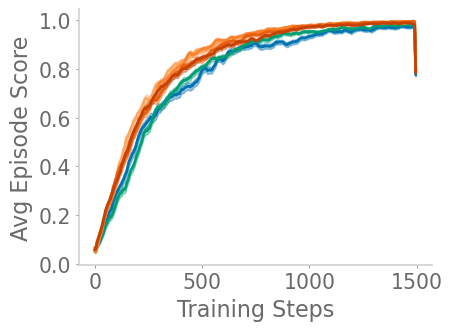

In [9]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=[
    'C0', 'C2',
    colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
new_df = df.copy()
smooth_line = True
new_df['episode'] = new_df['episode']//5*5
episodes = np.unique(new_df['episode'])
fig, ax = plt.subplots(figsize=(6.4*0.75, 4.8*0.75))
for _idx, model in enumerate(
     ['mf0', 'entro2', 'g0_-2_entro-1', 'g0.25_-2_entro0',
     'g0.5_-2_entro0', 'g0.8_-4_entro0']
    ):
    means = []
    sems = []
    for ep in episodes:
        vals = new_df[(new_df['model']==model) & (new_df['episode']==ep)]
        vals = vals['valid_score']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = smooth(episodes, means, 5)
    sems = smooth(episodes, sems, 5)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
        
    ax.plot(episodes[:-1], means[:-1], label=model, color=colors[_idx])
    ax.fill_between(
        episodes[:-1], mean_lowerbound[:-1],
        mean_upperbound[:-1], alpha=0.4, color=colors[_idx])
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.tight_layout()
plt.savefig('foraging.png', dpi=300, transparent=True)
plt.show()

# Modifying epsilon to test goal transfer for $\gamma$

In [84]:
base = 'frozenrandomtransfer_new_gridworld8x8_eps0.1_shuffobs'
net_yaml = 'dm_large_q'
z = 17

In [85]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/{base}_{net_yaml}_dim{z}/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(base, z, pfiles, net_yaml)

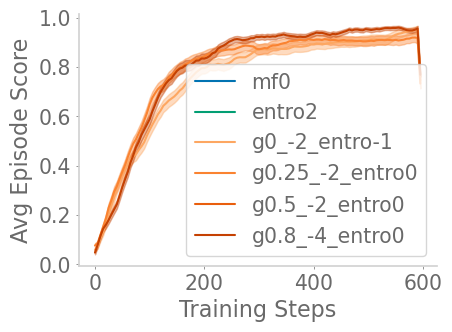

In [86]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=[
    'C0', 'C2',
    colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
new_df = df.copy()
smooth_line = True
new_df['episode'] = new_df['episode']//5*5
episodes = np.unique(new_df['episode'])
fig, ax = plt.subplots(figsize=(6.4*0.75, 4.8*0.75))
for _idx, model in enumerate(
     ['mf0', 'entro2', 'g0_-2_entro-1', 'g0.25_-2_entro0',
     'g0.5_-2_entro0', 'g0.8_-4_entro0']
    #np.unique(new_df['model'])
    ):
    means = []
    sems = []
    for ep in episodes:
        vals = new_df[(new_df['model']==model) & (new_df['episode']==ep)]
        vals = vals['valid_score']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = smooth(episodes, means, 5)
    sems = smooth(episodes, sems, 5)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
        
    ax.plot(episodes[:-1], means[:-1], label=model, color=colors[_idx])
    ax.fill_between(
        episodes[:-1], mean_lowerbound[:-1],
        mean_upperbound[:-1], alpha=0.4, color=colors[_idx])
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.tight_layout()
plt.legend()
plt.savefig('foraging.png', dpi=300, transparent=True)
plt.show()

# Modifying transitions to test transfer for $\gamma$

In [34]:
base = 'transitionreval_new_gridworld8x8_shuffobs'
net_yaml = 'dm_large_q'
z = 17

In [35]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/{base}_{net_yaml}_dim{z}/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(base, z, pfiles, net_yaml)

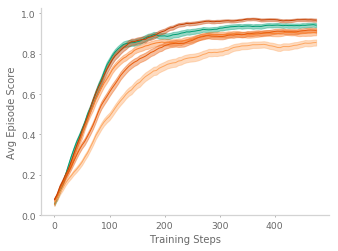

In [36]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=[
    'C0', 'C2',
    colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
new_df = df.copy()
smooth_line = True
new_df['episode'] = new_df['episode']//5*5
episodes = np.unique(new_df['episode'])
fig, ax = plt.subplots(figsize=(6.4*0.75, 4.8*0.75))
for _idx, model in enumerate(
     ['mf', 'entro2', 'g0_-2_entro-1', 'g0.25_-2_entro0',
     'g0.5_-2_entro0', 'g0.8_-4_entro0']
    #np.unique(new_df['model'])
    ):
    means = []
    sems = []
    for ep in episodes:
        vals = new_df[(new_df['model']==model) & (new_df['episode']==ep)]
        vals = vals['valid_score']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = np.array(means)
    sems = np.array(sems)
    smooth_n = 5
    means = smooth(episodes, means, smooth_n)
    sems = smooth(episodes, sems, smooth_n)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
        
    ax.plot(episodes[:-smooth_n], means[:-smooth_n], label=model, color=colors[_idx])
    ax.fill_between(
        episodes[:-smooth_n], mean_lowerbound[:-smooth_n],
        mean_upperbound[:-smooth_n], alpha=0.4, color=colors[_idx])
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.tight_layout()
plt.savefig('foraging.png', dpi=300, transparent=True)
plt.show()

In [37]:
base = 'transitionreval_new_gridworld8x8_eps0.4_shuffobs'
net_yaml = 'dm_large_q'
z = 17

In [38]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/{base}_{net_yaml}_dim{z}/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(base, z, pfiles, net_yaml)

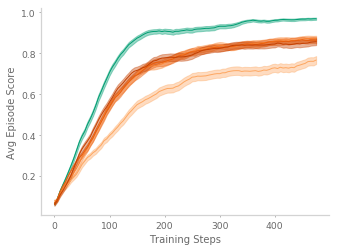

In [39]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=[
    'C0', 'C2',
    colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
new_df = df.copy()
smooth_line = True
new_df['episode'] = new_df['episode']//5*5
episodes = np.unique(new_df['episode'])
fig, ax = plt.subplots(figsize=(6.4*0.75, 4.8*0.75))
for _idx, model in enumerate(
     ['mf', 'entro2', 'g0_-2_entro-1', 'g0.25_-2_entro0',
     'g0.5_-2_entro0', 'g0.8_-4_entro0']
    #np.unique(new_df['model'])
    ):
    means = []
    sems = []
    for ep in episodes:
        vals = new_df[(new_df['model']==model) & (new_df['episode']==ep)]
        vals = vals['valid_score']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = np.array(means)
    sems = np.array(sems)
    smooth_n = 5
    means = smooth(episodes, means, smooth_n)
    sems = smooth(episodes, sems, smooth_n)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
        
    ax.plot(episodes[:-smooth_n], means[:-smooth_n], label=model, color=colors[_idx])
    ax.fill_between(
        episodes[:-smooth_n], mean_lowerbound[:-smooth_n],
        mean_upperbound[:-smooth_n], alpha=0.4, color=colors[_idx])
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.tight_layout()
plt.savefig('foraging.png', dpi=300, transparent=True)
plt.show()

# Larger encoder

In [197]:
base = 'gridworld8x8_largeencoder'
net_yaml = 'dm_large_encoder'
z = 6

In [198]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/{base}_{net_yaml}_dim{z}/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(base, z, pfiles, net_yaml)

In [199]:
np.unique(df['model'])

array(['entro-1', 'entro1', 'entro_0', 'g0.25_-3_entro-1',
       'g0.25_-3_entro0', 'g0.5_-3_entro-1', 'g0.5_-3_entro0',
       'g0.8_-4_entro-1', 'g0.8_-4_entro0', 'g0_-2_entro-1',
       'g0_-2_entro0'], dtype=object)

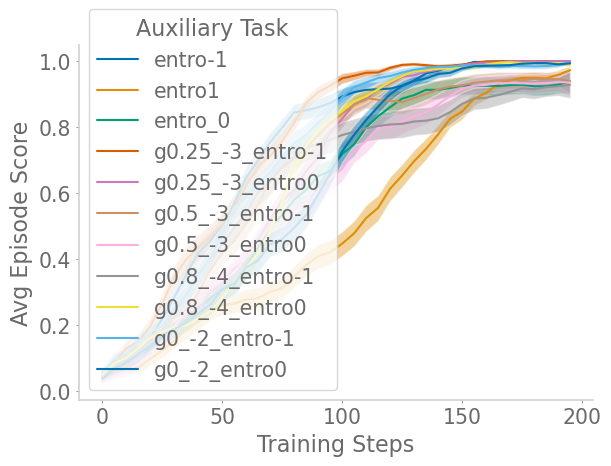

In [200]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
new_df = df.copy()
smooth_line = True
new_df['episode'] = new_df['episode']//5*5
episodes = np.unique(new_df['episode'])
fig, ax = plt.subplots()
for _idx, model in enumerate(
    np.unique(new_df['model'])
    #['mf', 'entro_0', 'g0_-2_entro0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0']
    #['mf_2', 'mf_-1', 'mf', 'mf_1', 'mf_2', 'mf_3']
    ):
    means = []
    sems = []
    for ep in episodes:
        vals = new_df[(new_df['model']==model) & (new_df['episode']==ep)]
        vals = vals['valid_score']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = np.array(means)
    sems = np.array(sems)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
    if smooth_line:
        means = smooth(episodes, means, 3)
        mean_lowerbound = smooth(episodes, mean_lowerbound)
        mean_upperbound = smooth(episodes, mean_upperbound)
    ax.plot(episodes[:-1], means[:-1], label=model)#, color=colors[_idx])
    ax.fill_between(
        episodes[:-1], mean_lowerbound[:-1],
        mean_upperbound[:-1], alpha=0.4#, color=colors[_idx]
        )
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.legend(title='Auxiliary Task', loc='lower left')
plt.tight_layout()
plt.savefig('foraging.png', dpi=300, transparent=True)
plt.show()

# Alternating-T

In [30]:
base = 'new_altT_eps0.4_tlen9_mlen5'
net_yaml = 'dm'
z = 24

In [31]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/{base}_{net_yaml}_dim{z}/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(base, z, pfiles, net_yaml)

In [32]:
np.unique(df['model'])

array(['g0_-2_entro-2'], dtype=object)

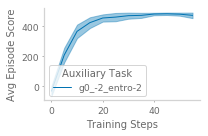

In [33]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
new_df = df.copy()
smooth_line = True
new_df['episode'] = new_df['episode']//5*5
episodes = np.unique(new_df['episode'])
fig, ax = plt.subplots(figsize=(3,2))
for _idx, model in enumerate(
    np.unique(new_df['model'])
    ):
    means = []
    sems = []
    for ep in episodes:
        vals = new_df[(new_df['model']==model) & (new_df['episode']==ep)]
        vals = vals['valid_score']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = np.array(means)
    sems = np.array(sems)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
    if smooth_line:
        means = smooth(episodes, means, 3)
        mean_lowerbound = smooth(episodes, mean_lowerbound)
        mean_upperbound = smooth(episodes, mean_upperbound)
    ax.plot(episodes[:-1], means[:-1], label=model, color=colors[_idx])
    ax.fill_between(
        episodes[:-1], mean_lowerbound[:-1],
        mean_upperbound[:-1], alpha=0.4, color=colors[_idx])
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.legend(title='Auxiliary Task', loc='lower left')
plt.tight_layout()
plt.show()

# Poort Task

In [26]:
base = 'poorttask'
net_yaml = 'dm'
z = 32

In [27]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/{base}_{net_yaml}_dim{z}/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(base, z, pfiles, net_yaml)

In [28]:
np.unique(df['model'])

array(['g0_-1_entro-2', 'mf0', 'noq_g0_-1_entro-2'], dtype=object)

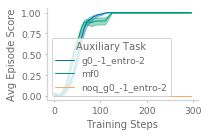

In [29]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
new_df = df.copy()
smooth_line = True
new_df['episode'] = new_df['episode']//5*5
episodes = np.unique(new_df['episode'])
fig, ax = plt.subplots(figsize=(3,2))
for _idx, model in enumerate(
    np.unique(df['model'])
    ):
    means = []
    sems = []
    for ep in episodes:
        vals = new_df[(new_df['model']==model) & (new_df['episode']==ep)]
        vals = vals['valid_score']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = np.array(means)
    sems = np.array(sems)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
    if smooth_line:
        means = smooth(episodes, means, 3)
        mean_lowerbound = smooth(episodes, mean_lowerbound)
        mean_upperbound = smooth(episodes, mean_upperbound)
    ax.plot(episodes[:-1], means[:-1], label=model, color=colors[_idx])
    ax.fill_between(
        episodes[:-1], mean_lowerbound[:-1],
        mean_upperbound[:-1], alpha=0.4, color=colors[_idx]
        )
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.legend(title='Auxiliary Task', loc='lower left')
plt.tight_layout()
plt.show()